# Reduce and merge correlation matrices

In [1]:
import re
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import helper_fcts

Load *df_parameter* DataFrame:

In [2]:
df_par = pd.read_pickle('df_parameter.p')
display(df_par.head())

df_par.shape

,gBB,gCC,gAB,gAC,gBC,path
0,-1.0,-1.0,-1.0,-1.0,-1.0,data/batch_001/run_00001
1,-1.0,-1.0,-1.0,-1.0,-0.8,data/batch_001/run_00002
2,-1.0,-1.0,-1.0,-1.0,-0.6,data/batch_001/run_00003
3,-1.0,-1.0,-1.0,-1.0,-0.4,data/batch_001/run_00004
4,-1.0,-1.0,-1.0,-1.0,-0.2,data/batch_001/run_00005


(18014, 6)

In [3]:
df_par.loc[:, 'gBB'].unique()
df_par.loc[:, 'gBC'].unique()

array([-1.  , -0.8 , -0.6 , -0.4 , -0.2 ,  0.  ,  0.2 ,  0.4 ,  0.6 ,
        0.8 ,  1.  , -0.5 ,  0.5 , -0.05,  0.05])

In [3]:
n_grid = 200  # size of grid

# create labels for columns, these correspond to the upper triangular of a matrix
cols_x1x2 = [f"x{j+1}_x{i+1}" for i in range(n_grid) for j in range(i+1)]

print(cols_x1x2[:10])

['x1_x1', 'x1_x2', 'x2_x2', 'x1_x3', 'x2_x3', 'x3_x3', 'x1_x4', 'x2_x4', 'x3_x4', 'x4_x4']


# 1 Add correlation matrices to Dataframe

Load npz-files and add pixels as features

1. Create new dataframe with flattened npz-matrices as rows and x1-x2 values as columns
2. Concat parameter df and correlation-matrix df

## 1.1 First attempt: Reading all at once (not working)

Load npz-files and add pixels as features

1. Create new dataframe with flattened npz-matrices as rows and x1-x2 values as columns
2. Concat parameter df and correlation-matrix df

## 1.2 Second attempt: Store as pickles and concat

1. Load npz files and change to float32.
2. Correlation functions are symmetric, therefore, store only upper triangular.
3. Flatten correlation matrices, they denote the rows of the DataFrames.
4. Store DataFrames in chunks of 1000 as pickles.
5. Restart notebook to drop loaded memory.
6. Reload DataFrames and concat them to a big DataFrame.
7. Store it as a pickle.

1\. First check if storing the matrices with float16-type is still acceptable or we should go with float32.

In [ ]:
gBB, gCC, gAB, gAC, gBC = 1.0, 1.0, -1.0, 0.2, 0.2
mask = (
    (df_par.loc[:, 'gBB'] == gBB) &
    (df_par.loc[:, 'gCC'] == gCC) &
    (df_par.loc[:, 'gAB'] == gAB) &
    (df_par.loc[:, 'gAC'] == gAC) &
    (df_par.loc[:, 'gBC'] == gBC)
)
corrBC_example = np.load(df_par.loc[mask, 'path'].iloc[0] + '/correlation_fct_BC.npz')['corrBC']



xgrid = np.linspace(-2.5, 2.5, 200)
x, y = np.meshgrid(xgrid, xgrid)
corrBC_float64 = np.array(corrBC_example, dtype=np.float64)
corrBC_float32 = np.array(corrBC_example, dtype=np.float32)
corrBC_float16 = np.array(corrBC_example, dtype=np.float16)

print(np.abs(corrBC_float64 - corrBC_float32).max())
print(np.abs(corrBC_float64 - corrBC_float16).max())
print(np.abs(corrBC_float32 - corrBC_float16).max())


Float32 and float16 seems to be fine. However, continue with float32.

Steps: 2. - 4.
- flatten upper triangular and store DataFrames in chunks

In [ ]:
if False:  # Execute only once, to preserve memory
    corr_list = []
    count = 0
    for i, path_npz in enumerate(df_par.loc[:, 'path']):

        corrBC = np.load(path_npz + '/correlation_fct_BC.npz')['corrBC']
        
        # flatten the upper triangular and reduce precision
        corrBC_flat = corrBC[np.triu_indices(n_grid)].astype(np.float32)
 
        corr_list.append(corrBC_flat)

        if (i+1) % 1000 == 0:
            count += 1
            df_corr = pd.DataFrame(corr_list, columns=cols_x1x2)
            print(count, df_corr.shape)
            df_corr.to_pickle(f'data/df_corr_batch_{count:02d}.p')
            corr_list = []
    df_corr = pd.DataFrame(corr_list, columns=cols_x1x2)
    count += 1
    print(count, df_corr.shape)
    df_corr.to_pickle(f'data/df_corr_batch_{count:02d}.p')

Steps: 5. - 7.

- restart notebook, reload, concat and save as pickle
- the batch numbers range from 0 to 19

In [4]:
df_corr_list = [pd.read_pickle(f'data/df_corr_batch_{count:02d}.p') for count in range(1, 20)]

df_corr = pd.concat(df_corr_list, axis=0)
df_corr = df_corr.reset_index(drop=True)

In [13]:
df_corr.shape

(18014, 20100)

In [14]:
df_corr.to_pickle(f'data/df_corr.p')

# 2 Reduce correlation DataFrame further with PCA

1. Restart notebook and skip the above part (except the lines unitl Sec. 1) to only load the df_corr.p into memory (otherwise it can happen that the kernel dies in the following, at least on my local laptop).
2. Standardize data and apply PCA.
3. Check that the applied PCA does not destroy relevant information.

Start with step 1:

In [3]:
df_corr = pd.read_pickle('data/df_corr.p')

Continue with step 2: Use Principle Component analysis to reduce the number of columns further.

In [4]:
n_comp = 10

pipe_pca = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=n_comp, random_state=42))
])

arr_corr = pipe_pca.fit_transform(df_corr)

Check results (steps 3)

In [5]:
expl_var = pipe_pca.named_steps['pca'].explained_variance_ratio_

print('Explained variance:', sum(expl_var))

Explained variance: 0.9984993454439589


- Explained variance for n_comp=2:  0.8722
- Explained variance for n_comp=5:  0.9885
- Explained variance for n_comp=10: 0.9985
- Explained variance for n_comp=15: 0.9996
- Explained variance for n_comp=18: 0.9998
- Explained variance for n_comp=20: 0.999888
- Explained variance for n_comp=25: 0.999962
- Explained variance for n_comp=35: 0.999993
- Explained variance for n_comp=50: 0.9999991

Transform back and invert Standardscaler:

In [6]:
print('arr_corr:', arr_corr.shape, 'principal components')
print(pipe_pca.named_steps['pca'].components_.shape, 'pca coefficients')


# needed to reconstruct decomposed correlation matrices
corr_backscaled = np.dot(arr_corr, pipe_pca.named_steps['pca'].components_)

corr_backscaled = pipe_pca.named_steps['std'].inverse_transform(corr_backscaled)

# np.savez('corr_mat_std_pca_backscaled.npz', corr_backscaled)


arr_corr: (18014, 10) principal components
(10, 20100) pca coefficients


Reconstruct correlation matrix:

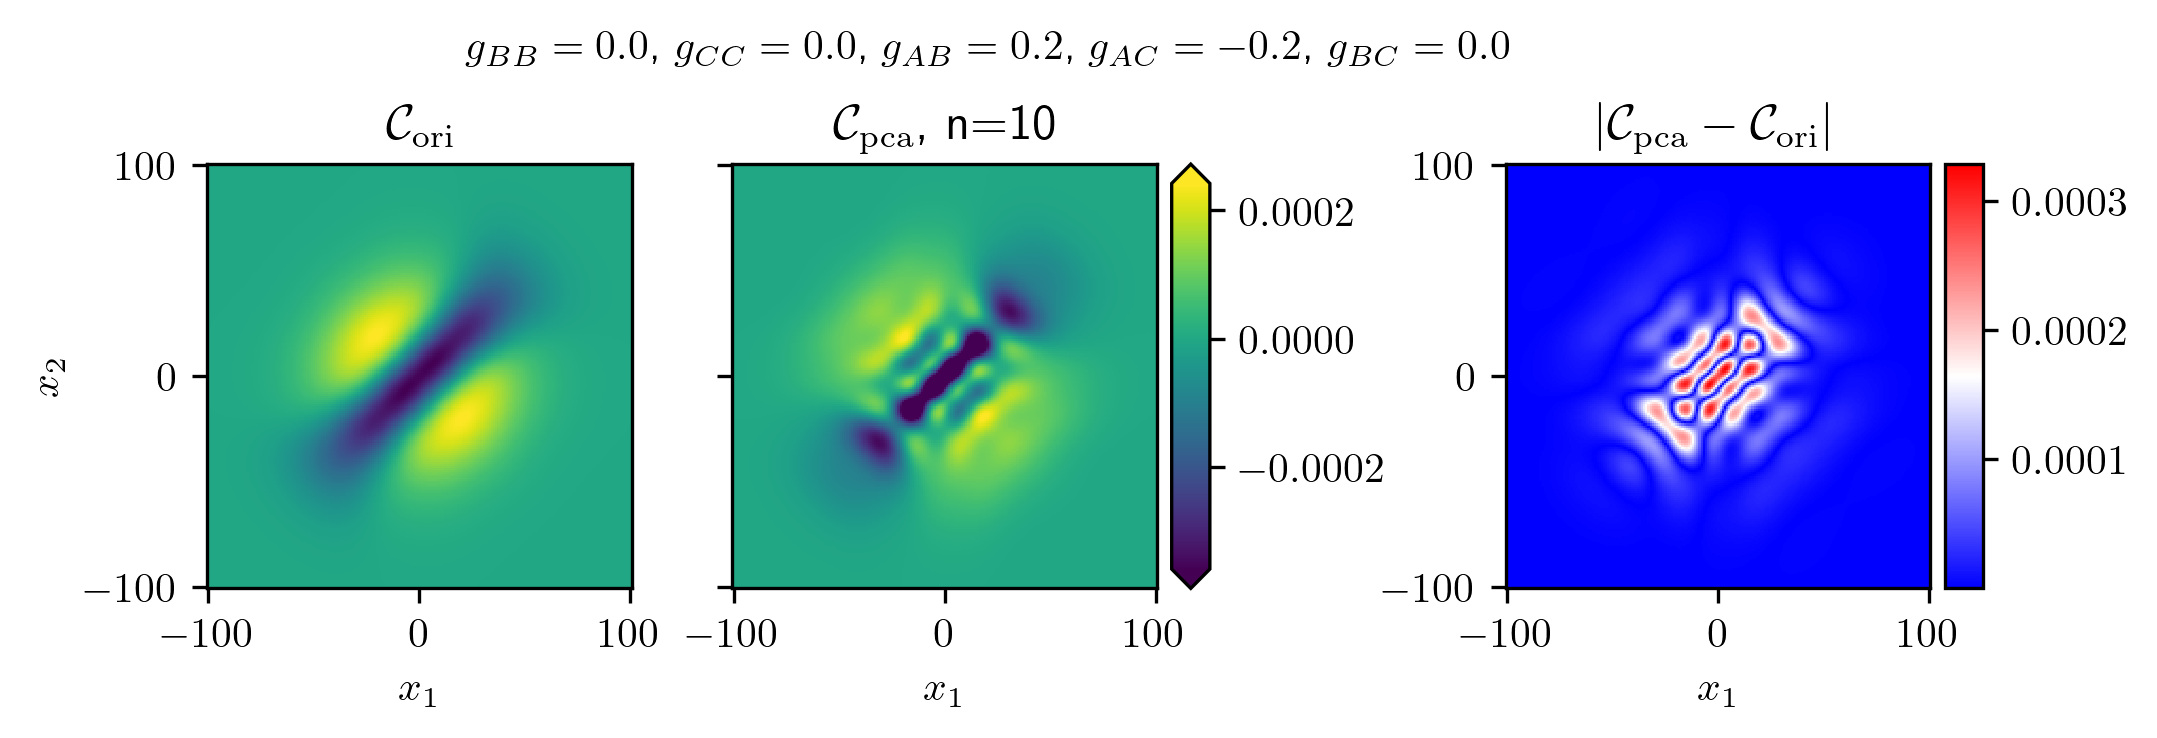

In [7]:
index = helper_fcts.get_index(df_par, gBB=0.0, gCC=0.0, gAB=0.2, gAC=-0.2, gBC=0.0)


helper_fcts.plot_backscaled_comparison(df_par, corr_backscaled, index=index, pca_n=n_comp, bool_save=True)
helper_fcts.plot_backscaled_comparison(df_par, corr_backscaled, index=index, pca_n=n_comp, bool_save=False)


In the above analysis we find that already 10 principal components can explain the variance up to 99%. However, the structure of the correlation matrix is not correctly captured by this approximation for weak interactions where the correlation matrices have small absolute values anyway $\sim 10^{-4}$. A value of 25 yields beeter results, however, with n=50 we receive the most adequate results. Here the absolute difference is of the order of $\sim 10^{-5}$.
We proceed with this value.

# 3 Merge df_corr and df_par

In [8]:
df_corr_pca = pd.DataFrame(arr_corr, columns=[f'pca comp {i}' for i in range(1, n_comp+1)])

In [9]:
df_main = pd.merge(
    left=df_par,
    right=df_corr_pca,
    how='inner',
    left_index=True,
    right_index=True
)
df_main.head()

,gBB,gCC,gAB,gAC,gBC,path,pca comp 1,pca comp 2,pca comp 3,pca comp 4,...,pca comp 26,pca comp 27,pca comp 28,pca comp 29,pca comp 30,pca comp 31,pca comp 32,pca comp 33,pca comp 34,pca comp 35
0,-1.0,-1.0,-1.0,-1.0,-1.0,data/batch_001/run_00001,-105.659465,37.965591,75.525219,0.440110,...,-0.579794,-0.262876,1.423634,-0.342301,-1.893036,0.035372,-0.163589,-0.148281,0.049522,1.502408
1,-1.0,-1.0,-1.0,-1.0,-0.8,data/batch_001/run_00002,-102.790897,32.000799,59.039534,0.308656,...,-0.131461,0.121099,0.258418,-0.293295,-1.524335,0.020061,0.049272,0.075778,0.029730,1.179234
2,-1.0,-1.0,-1.0,-1.0,-0.6,data/batch_001/run_00003,-98.020880,24.320418,41.510031,0.182524,...,0.048499,0.352482,-0.215220,-0.200258,-0.992447,0.008854,0.242488,0.286439,0.017504,0.915911
3,-1.0,-1.0,-1.0,-1.0,-0.4,data/batch_001/run_00004,-90.632865,14.695513,23.230042,0.067592,...,0.066520,0.241654,-0.258080,-0.084979,-0.410106,0.003208,0.409550,0.206876,0.002859,0.434153
4,-1.0,-1.0,-1.0,-1.0,-0.2,data/batch_001/run_00005,-79.346890,4.165145,4.233191,-0.034407,...,0.061075,0.062584,-0.130982,-0.059327,-0.308299,0.002651,0.288090,0.067318,-0.004575,0.090350


In [14]:
df_main.shape

(18014, 56)

In [10]:
df_main.to_pickle(f'df_main_std_pca_{n_comp}.p')